In [2]:
from files.utils.utility_functions import *
from files.pif.pif import *

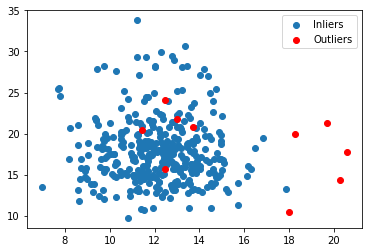

In [3]:
def read_csv(path):
    with open(path, "r") as f:
        content = f.read().split("\n")
    content = [list(map(lambda x: 1 if x=="\"n\"" else 0 if x=="\"o\"" else float(x), c.split(","))) for c in content]
    return np.array(content)



path = r"/home/catonz/Neural-PreferenceIsolation/datasets/breast-cancer-unsupervised-ad.csv"

dataset = read_csv(path)

gt = dataset[:,-1]

dataset = np.delete(dataset, -1, axis=1)

inliers = np.where(gt == 1)
outliers = np.where(gt == 0)

plt.scatter(dataset[:,0][inliers],  dataset[:,1][inliers], label="Inliers")
plt.scatter(dataset[:,0][outliers], dataset[:,1][outliers], c="r", label="Outliers")
plt.legend()

In [4]:
dataset.shape

(367, 30)

In [5]:
len(np.where(gt == 1)[0]), len(np.where(gt == 0)[0])

(357, 10)

In [29]:
params = {
    "root_path": "/home/catonz/Neural-PreferenceIsolation",

    "mss": len(dataset),
    "num_models": 100,
    "training_epochs": 200,

    "models_to_use": ["ae"],

    "AE_structure": {
        "neurons": [30, 64, 16, 10, 16, 64, 30],
        "activation": torch.tanh
    },
}

pif = PreferenceIsolationForest(data=dataset, model_name=AE)
scores = pif.anomaly_detection(params=params)

Anomaly Detection
--------------------------------------------------
Building RanSac models
Iteration 100/100: [==============================] (100%) ETA: 0:09:04.809258
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


In [32]:
from sklearn.ensemble import IsolationForest as iFor

ifor = iFor().fit(dataset)
scores_ifor = -ifor.score_samples(dataset)
ifor_auc, *_ = make_roc(gt, scores_ifor, show=False, to_plot=False);
print("iFor AUC: ", ifor_auc)

iFor AUC:  0.9781512605042016


In [31]:
pif_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

PIF AUC:  0.49299719887955185


In [106]:
from files.classes.neural_models import *

nen = NeuralNetwork(neurons=[30, 16, 8, 4, 2, 4, 8, 16, 30], activation=torch.relu)
nen.fit(epochs=500, data=dataset[np.random.randint(0, len(dataset), (30,))], print_training=True, bs=32)
scores = nen.get_residuals(dataset)

Epoch 500/500: [==============================] (100%) ETA: 0:00:00.003175 Mean Loss: 981.38777


In [107]:
pif_auc, *_ = make_roc(gt, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

PIF AUC:  0.9974789915966387


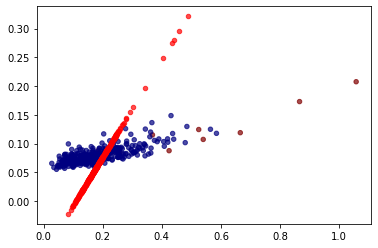

In [116]:
dims = [25,29]
preds = nen.predict(dataset)
plot(dataset[:,dims], c=~gt.astype(bool))
plot(preds[:,dims], c="r")

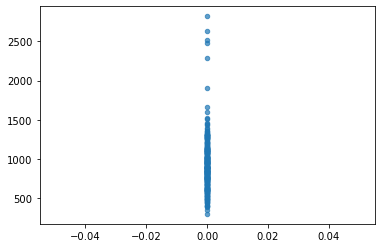

In [109]:
x = torch.FloatTensor(dataset.copy())
for l in nen.layers[:3]:
    x = torch.relu(l(x))
preds = x.detach().numpy()

plot(preds)

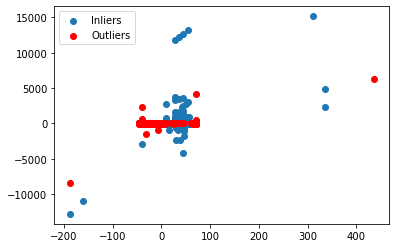

In [127]:
path = r"/home/catonz/Neural-PreferenceIsolation/datasets/shuttle-unsupervised-ad.csv"

dataset2 = read_csv(path)

gt2 = dataset2[:,-1]

dataset2 = np.delete(dataset2, -1, axis=1)

inliers = np.where(gt2 == 1)
outliers = np.where(gt2 == 0)

x_dim = 4
y_dim = 5

plt.scatter(dataset2[:,x_dim][inliers],  dataset2[:,y_dim][inliers], label="Inliers")
plt.scatter(dataset2[:,x_dim][outliers], dataset2[:,y_dim][outliers], c="r", label="Outliers")
plt.legend()

In [166]:
params = {
    "root_path": "/home/catonz/Neural-PreferenceIsolation",

    "mss": 10,
    "num_models": 100,
    "training_epochs": 200,

    "models_to_use": ["ae"],

    "AE_structure": {
        "neurons": [9, 2, 9],
        "activation": torch.relu
    },
}

pif = PreferenceIsolationForest(data=dataset, model_name=AE)
scores = pif.anomaly_detection(params=params)

Anomaly Detection
--------------------------------------------------
Building RanSac models
Iteration 100/100: [==============================] (100%) ETA: 0:00:11.334987
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


In [167]:
pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

PIF AUC:  0.4861212035385919


In [168]:
from sklearn.ensemble import IsolationForest as iFor

ifor = iFor().fit(dataset2)
scores_ifor = -ifor.score_samples(dataset2)
ifor_auc, *_ = make_roc(gt2, scores_ifor, show=False, to_plot=False);
print("iFor AUC: ", ifor_auc)

iFor AUC:  0.9972698977336585


In [189]:
nen = NeuralNetwork(neurons=[9, 2, 9], activation=torch.relu)
nen.fit(epochs=50, data=dataset2[np.random.randint(0, len(dataset2), params["mss"])], print_training=True, bs=2)
scores = nen.get_residuals(dataset2)
pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
print("PIF AUC: ", pif_auc)

Epoch 50/50: [==============================] (100%) ETA: 0:00:00.004600 Mean Loss: 194.06433
PIF AUC:  0.992482106213523


In [193]:
for nen in pif.models:
#     nen = pif.models[1]
    scores = nen.get_residuals(dataset2)
    pif_auc, *_ = make_roc(gt2, scores, show=False, to_plot=False);
    print("PIF AUC: ", pif_auc)

PIF AUC:  0.988479233773467
PIF AUC:  0.9888616994367551
PIF AUC:  0.989069097364045
PIF AUC:  0.9888187007820308
PIF AUC:  0.9885959622539271
PIF AUC:  0.9888213741440619
PIF AUC:  0.9888140036599576
PIF AUC:  0.989184376732376
PIF AUC:  0.9890195027506645
PIF AUC:  0.9887575632410022
PIF AUC:  0.9885428447989916
PIF AUC:  0.9896097411116209
PIF AUC:  0.9886760881607839
PIF AUC:  0.9890139311643756
PIF AUC:  0.98918854917592
PIF AUC:  0.9887585376439856
PIF AUC:  0.9886977249039514
PIF AUC:  0.9885578106294273
PIF AUC:  0.9888640979671754
PIF AUC:  0.9885831950763767
PIF AUC:  0.9885338752946069
PIF AUC:  0.9886052565593061
PIF AUC:  0.9887728538724324
PIF AUC:  0.988669841987814
PIF AUC:  0.9885191093417063
PIF AUC:  0.9884708389169955
PIF AUC:  0.9887869952080361
PIF AUC:  0.9886933525828724
PIF AUC:  0.9889095201370122
PIF AUC:  0.9886062059775975
PIF AUC:  0.9887746527702476
PIF AUC:  0.9886061560082138
PIF AUC:  0.9886334392917459
PIF AUC:  0.988536348779103
PIF AUC:  0.988675338

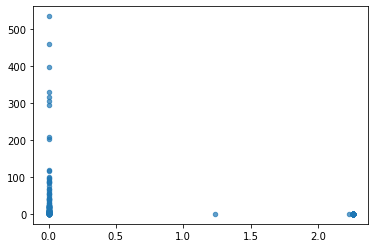

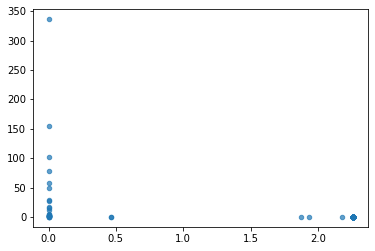

In [194]:
x = torch.FloatTensor(dataset.copy())
for l in nen.layers[:3]:
    x = torch.relu(l(x))
preds = x.detach().numpy()

plot(preds[inliers])
plt.figure()
plot(preds[outliers])